In [1]:
from qiskit import QuantumCircuit, execute, transpile, assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from math import sqrt, pi

from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector

import numpy as np
import IPython.display as ipd

import math
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [2]:
def subband_mapping(critical_bands, X_f): ##Might need to put this in a class
    """
    This is the classical version of huffman mapping. This is used to compress the information
    into the quantum circuit.
    """
    original_mapping = {}
    magnitudes = np.linspace(0,len(critical_bands))
    # just use 5 qubits/bits
    zhead = ''
    
    lower_band = 0
    for i, band in enumerate( critical_bands ):
        binary_code = str(bin(i))[2:]
        if len(binary_code) < 5:
            zfill = 5 - len(binary_code)
            for z in np.zeros(zfill):
                zhead += str(int(z))
                
            binary_code = zhead + binary_code
        zhead = ''  
        
        magnitudes[i] = round(np.max(np.real(X_f[lower_band:band])),3)
        lower_band = band
        
        original_mapping[binary_code] = magnitudes[i]
        
    return original_mapping

In [3]:
def qft_rotations( circuit, n ):
    """
    n is the qubit number that the QFT is being applied to, and
    the circuit is the circuit that is being fed into the QFT
    """
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    
    for qubit in range( n ): # look up what a controlled p gate is
        circuit.cp( pi/2**(n-qubit), qubit, n ) #said  Ok keep in mind that both qubits have to be 1 in order for the phase shoft to occur.
        
    qft_rotations( circuit, n )

In [4]:
def qft( circuit, n ):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [5]:
def inverse_qft( circuit, n ):
    """Does the inverse QFT on the first n qubits in circuit"""
    qft_circ = qft( QuantumCircuit(n), n )
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()

In [6]:
def swap_registers( circuit, n ): ## These can be implemented using altenrating CNOT gates
    for qubit in range(n//2):
        circuit.swap( qubit, n-qubit-1 )
    return circuit

## Implementing Paper: Quantum Arithmetic with the Quantum Fourier Transform

In [7]:
def b_rotations( circuit, a, b, tot_qb ):
    print(a,b)
    shift = tot_qb - b
    b += shift
    print(a,b)
    
    if a == 0:
        return circuit
    else:
        a -= 1
        for qubit in range( a+1, b ): # look up what a controlled p gate is
            circuit.cp( pi/2**(qubit), qubit, a ) #said  Ok keep in mind that both qubits have to be 1 in order for the phase shoft to occur.

        b_rotations( circuit, a, b, tot_qb  )

def qft_add( circuit, a, b ):
    """
    This function adds two numbers in register a and register b
    using rotations in the phase domain
    """
    tot_qb = a + b
    
    circuit.barrier()
    qft( circuit, a )
    
    circuit.barrier()
    b_rotations( circuit, a, b, tot_qb )
    
    circuit.barrier()
    inverse_qft( circuit, a )
    
    circuit.barrier()

In [8]:
def QuantumCircuit_gen(QR_1, QR_2, CR, psi, psi_2):
    
    QR = QR_1 + QR_2
    
    qc = QuantumCircuit( QR,CR )
    qc.initialize( psi, np.arange(QR_1))
    qc.initialize( psi_2, np.arange(QR_1,QR_2+QR_1) )
    
    qft_add( qc, QR_1, QR_2 )

    for i in range(QR_1):
        qc.measure( i,i )
        
    return qc

In [9]:
pi = np.pi
cos = np.cos
sin = np.sin

fs = 48000
step = 1/fs
t = np.arange(0,10.0,step)
critical_bands = [100,200,300,400,510,630,770,920,1080,1270,1480,
                  1720,2000,2320,2700,3150,3700,4400,5300,6400,7700,
                  9500,12000,15500]

## Test Signal Parameters~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
f0 = 50
f1 = 220; f2 = 400; f3 = 600
f4 = 1000; f5 = 2500

/Users/scottoshiro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-10-51c6584eb21e>:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[2].semilogx(X_f, '-r');axs[2].grid(); axs[2].set_xlim(0,24000)
/Users/scottoshiro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-10-51c6584eb21e>:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[2].semilogx(B_f, '-b');axs[2].grid(); axs[2].set_xlim(0,24000)
/Users/scottoshiro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imag

Text(0.5, 1.0, 'Signal A+B FFT')

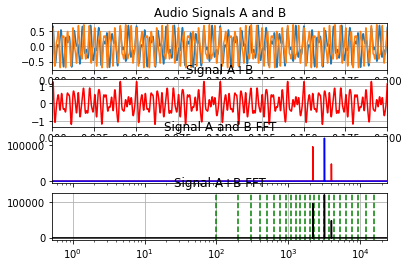

In [10]:
x = 0.4*cos(2*pi*220*t) + 0.20*cos(2*pi*400*t) + 0.20*sin(2*pi*f2*t) #+ 0.10*cos(2*pi*f4*t)
b = 0.5*cos(2*pi*320*t) + 0.20*sin(2*pi*600*t)

X_f = np.fft.fft(x)
B_f = np.fft.fft(b)
add_sig = x+b

A_f = np.fft.fft(add_sig)
#X_f = X_fo[:int(len(X_fo)/2)]

fig, axs = plt.subplots(4)

axs[0].plot(t,x)
axs[0].plot(t,b)
axs[0].set_xlim(0,0.2); axs[0].grid()
axs[0].set_title("Audio Signals A and B")

axs[1].plot(t,x+b, '-r'); axs[1].grid(); axs[1].set_xlim(0,0.2)

for xc in critical_bands:
    plt.axvline(x=xc, color='g', linestyle='--')

axs[2].semilogx(X_f, '-r');axs[2].grid(); axs[2].set_xlim(0,24000)
axs[1].set_title("Signal A+B")
axs[2].semilogx(B_f, '-b');axs[2].grid(); axs[2].set_xlim(0,24000)
axs[2].set_title("Signal A and B FFT")
axs[3].semilogx(A_f, '-k');axs[3].grid(); axs[3].set_xlim(0,24000)
axs[3].set_title("Signal A+B FFT")

In [11]:
ipd.Audio(x, rate=fs)
ipd.Audio(b, rate=fs)
ipd.Audio(add_sig, rate=fs)

In [12]:
mag = subband_mapping(critical_bands, X_f) ## Revise when dealing with more complex signal 

#print(mag)
total = sum(mag.values()); print('total: ', total)

for index, code in enumerate(mag.keys()):
    mag[code] = np.sqrt(mag[code] / total)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mag_2 = subband_mapping(critical_bands, B_f) ## Revise when dealing with more complex signal 

print(mag_2)
total = sum(mag_2.values())#; print('total: ', total)

for index, code in enumerate(mag_2.keys()):
    mag_2[code] = np.sqrt(mag_2[code] / total)

total:  144000.0
{'00000': 0.0, '00001': 0.0, '00010': 0.0, '00011': 0.0, '00100': 0.0, '00101': 0.0, '00110': 0.0, '00111': 0.0, '01000': 0.0, '01001': 0.0, '01010': 0.0, '01011': 0.0, '01100': 0.0, '01101': 0.0, '01110': 0.0, '01111': 0.0, '10000': 120000.0, '10001': 0.0, '10010': 0.0, '10011': 0.0, '10100': 0.0, '10101': 0.0, '10110': 0.0, '10111': 0.0}


In [13]:
psi = list(mag.values())
print(math.ceil((np.log2(len(psi)))))
print(2**math.ceil((np.log2(len(psi)))) - len(psi))

padding = np.zeros( 2**math.ceil((np.log2(len(psi)))) - len(psi) )
psi = np.concatenate((np.array(psi), padding))
print(psi, type(psi))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

psi_2 = list(mag_2.values())
print(math.ceil((np.log2(len(psi_2)))))
print(2**math.ceil((np.log2(len(psi_2)))) - len(psi))

padding_2 = np.zeros( 2**math.ceil((np.log2(len(psi_2)))) - len(psi_2) )
psi_2 = np.concatenate((np.array(psi_2), padding_2))
print(psi_2, type(psi_2))


5
8
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.81649658 0.         0.         0.         0.57735027
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] <class 'numpy.ndarray'>
5
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] <class 'numpy.ndarray'>


In [14]:
qc = QuantumCircuit_gen(5,5,5,psi,psi_2)

5 5
5 10
4 10
4 10
3 10
3 10
2 10
2 10
1 10
1 10
0 10
0 10


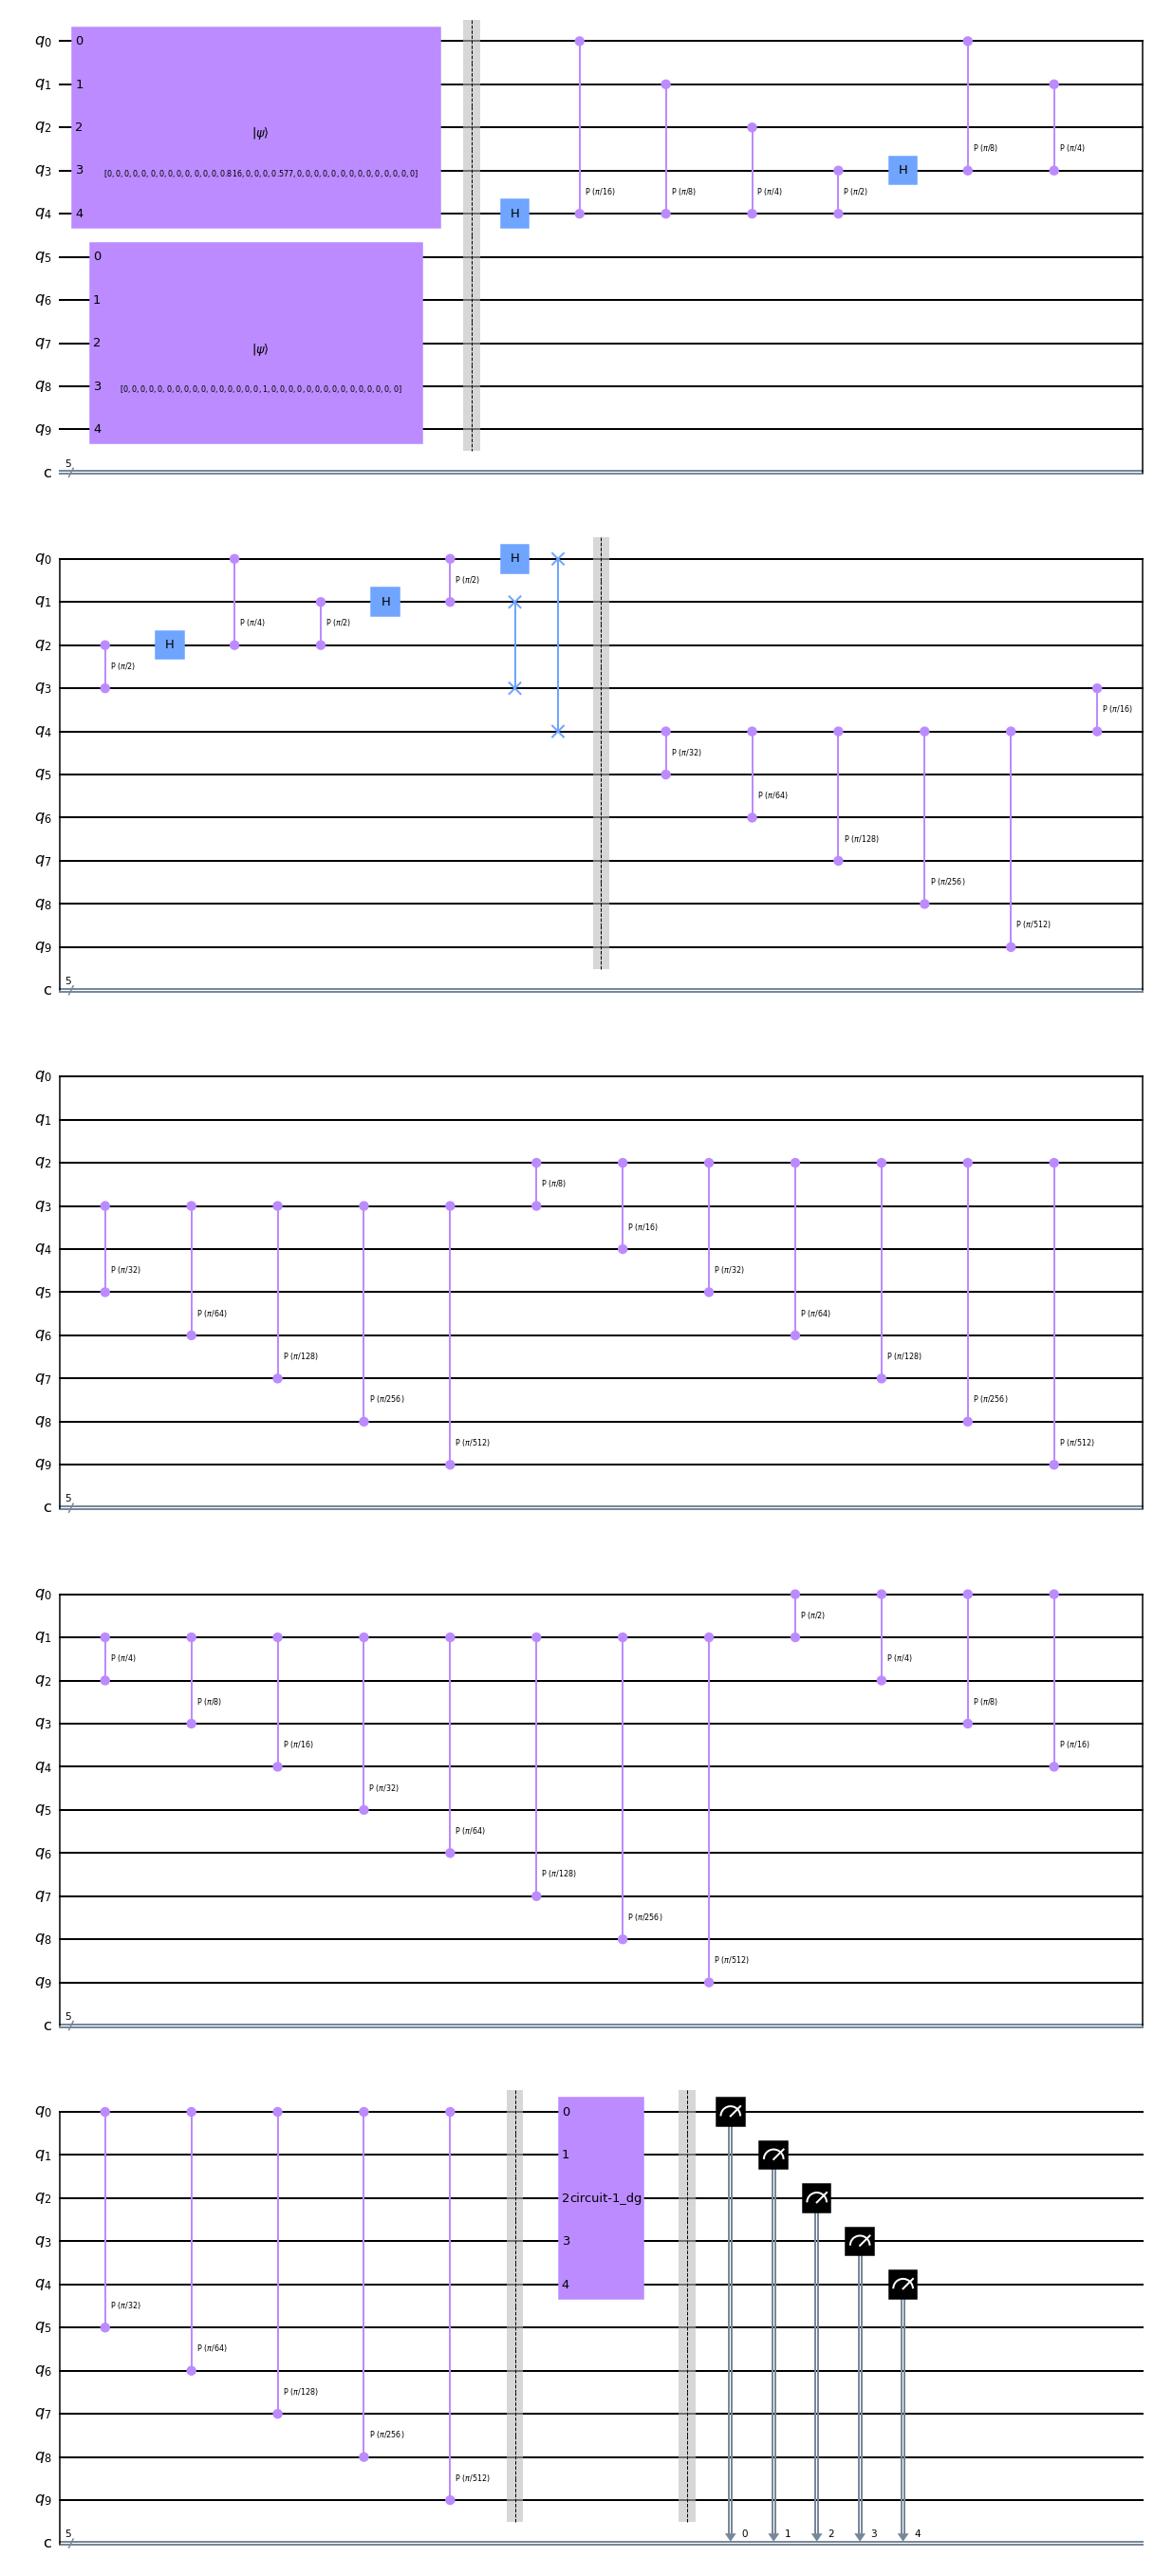

In [15]:
qc.draw(output='mpl')

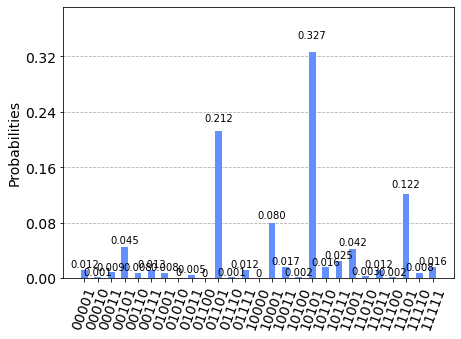

In [16]:
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 2048
t_qpe = transpile(qc, qasm_sim)
qobj = assemble(t_qpe, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [17]:
answer

{'01010': 2,
 '01100': 1,
 '10011': 34,
 '01110': 3,
 '00010': 3,
 '10100': 4,
 '00111': 26,
 '11110': 17,
 '11100': 4,
 '01101': 435,
 '10111': 51,
 '01001': 16,
 '11011': 24,
 '10101': 669,
 '00101': 93,
 '00110': 16,
 '11101': 249,
 '10000': 1,
 '11001': 87,
 '11111': 33,
 '10110': 32,
 '00011': 18,
 '00001': 25,
 '11010': 6,
 '01011': 11,
 '01111': 24,
 '10001': 164}

In [18]:
n_index = np.arange(0,len(answer))
print('n_index: ', n_index, len(n_index))
keys = list(answer.keys())

print(type(answer.keys()), type(keys))
samp_num = [int(k, 2) for k in keys]

zero_amp4 = [x for x in range(samp_num[0], samp_num[-1]+1) if x not in samp_num]
print(zero_amp4)

n_index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] 27
<class 'dict_keys'> <class 'list'>
[]


In [19]:
samp_1 = np.sort( samp_num )
zero_amp4 = [x for x in range(samp_num[0], samp_num[-1]+1) if x not in samp_1]
print(samp_1)

[ 1  2  3  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 25 26 27 28
 29 30 31]


In [20]:
def fillin(zero_amp, count_c):
    if keys != []:
        z_dict = {}
        for i in zero_amp:
            key = "{0:b}".format(i).zfill(qubit_num)
            z_dict[key] = 0

        res = {**answer, **z_dict}
    else:
        res = count_c
        
    return res

In [21]:
res = answer #fillin(samp_1, answer)
print(type(res), len(res))

<class 'qiskit.result.counts.Counts'> 27


In [22]:
res

{'01010': 2,
 '01100': 1,
 '10011': 34,
 '01110': 3,
 '00010': 3,
 '10100': 4,
 '00111': 26,
 '11110': 17,
 '11100': 4,
 '01101': 435,
 '10111': 51,
 '01001': 16,
 '11011': 24,
 '10101': 669,
 '00101': 93,
 '00110': 16,
 '11101': 249,
 '10000': 1,
 '11001': 87,
 '11111': 33,
 '10110': 32,
 '00011': 18,
 '00001': 25,
 '11010': 6,
 '01011': 11,
 '01111': 24,
 '10001': 164}

In [23]:
mapping_ans = {} ## Make into function here

zhead = ''
for i in range(2**5):
    code = str(bin(i))[2:]
    if len(code) < 5:
        pad = 5 - len(code)
        zfill = np.zeros(pad)
        for z in zfill:
            zhead += str(int(z))
        code = zhead + code
        zhead = ''
    mapping_ans[code] = 0

mapping_ans

{'00000': 0,
 '00001': 0,
 '00010': 0,
 '00011': 0,
 '00100': 0,
 '00101': 0,
 '00110': 0,
 '00111': 0,
 '01000': 0,
 '01001': 0,
 '01010': 0,
 '01011': 0,
 '01100': 0,
 '01101': 0,
 '01110': 0,
 '01111': 0,
 '10000': 0,
 '10001': 0,
 '10010': 0,
 '10011': 0,
 '10100': 0,
 '10101': 0,
 '10110': 0,
 '10111': 0,
 '11000': 0,
 '11001': 0,
 '11010': 0,
 '11011': 0,
 '11100': 0,
 '11101': 0,
 '11110': 0,
 '11111': 0}

In [24]:
for code in res.keys():
    mapping_ans[code] = res[code] 

In [25]:
mapping_ans

{'00000': 0,
 '00001': 25,
 '00010': 3,
 '00011': 18,
 '00100': 0,
 '00101': 93,
 '00110': 16,
 '00111': 26,
 '01000': 0,
 '01001': 16,
 '01010': 2,
 '01011': 11,
 '01100': 1,
 '01101': 435,
 '01110': 3,
 '01111': 24,
 '10000': 1,
 '10001': 164,
 '10010': 0,
 '10011': 34,
 '10100': 4,
 '10101': 669,
 '10110': 32,
 '10111': 51,
 '11000': 0,
 '11001': 87,
 '11010': 6,
 '11011': 24,
 '11100': 4,
 '11101': 249,
 '11110': 17,
 '11111': 33}

In [26]:
fc = np.zeros(len(mapping_ans))
lower_band = 0
for band, code in enumerate(mapping_ans):
    """We're going to be super general about this..Center them in the subband"""
    if band < len(critical_bands):
        fc[band] = (critical_bands[band] + lower_band) / 2
        lower_band = critical_bands[band]
    
fc

array([   50.,   150.,   250.,   350.,   455.,   570.,   700.,   845.,
        1000.,  1175.,  1375.,  1600.,  1860.,  2160.,  2510.,  2925.,
        3425.,  4050.,  4850.,  5850.,  7050.,  8600., 10750., 13750.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.])

In [27]:
fft_synthesis = np.zeros(len(X_f))
total_new = sum(mapping_ans.values())
print(fft_synthesis)
keys = list(mapping_ans.keys()); print(type(keys[0]))

for i, val in enumerate(fc):
    key = keys[i]
    fc_mag = mapping_ans[key]
    print(type(fc_mag), val, i)
    if i < 25:
        fft_synthesis[int(val)] = 19200 * (fc_mag / total_new)

[0. 0. 0. ... 0. 0. 0.]
<class 'str'>
<class 'int'> 50.0 0
<class 'int'> 150.0 1
<class 'int'> 250.0 2
<class 'int'> 350.0 3
<class 'int'> 455.0 4
<class 'int'> 570.0 5
<class 'int'> 700.0 6
<class 'int'> 845.0 7
<class 'int'> 1000.0 8
<class 'int'> 1175.0 9
<class 'int'> 1375.0 10
<class 'int'> 1600.0 11
<class 'int'> 1860.0 12
<class 'int'> 2160.0 13
<class 'int'> 2510.0 14
<class 'int'> 2925.0 15
<class 'int'> 3425.0 16
<class 'int'> 4050.0 17
<class 'int'> 4850.0 18
<class 'int'> 5850.0 19
<class 'int'> 7050.0 20
<class 'int'> 8600.0 21
<class 'int'> 10750.0 22
<class 'int'> 13750.0 23
<class 'int'> 0.0 24
<class 'int'> 0.0 25
<class 'int'> 0.0 26
<class 'int'> 0.0 27
<class 'int'> 0.0 28
<class 'int'> 0.0 29
<class 'int'> 0.0 30
<class 'int'> 0.0 31


Text(0, 0.5, 'Magnitude')

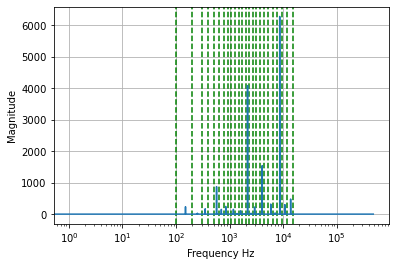

In [28]:

for xc in critical_bands:
    plt.axvline(x=xc, color='g', linestyle='--')
plt.semilogx(fft_synthesis); plt.grid();plt.xlabel('Frequency Hz'); plt.ylabel('Magnitude')

/Users/scottoshiro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Magnitude')

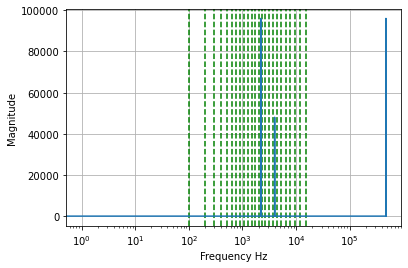

In [29]:
for xc in critical_bands:
    plt.axvline(x=xc, color='g', linestyle='--')
plt.semilogx(X_f); plt.grid();plt.xlabel('Frequency Hz'); plt.ylabel('Magnitude')

/Users/scottoshiro/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(2000.0, 8000.0)

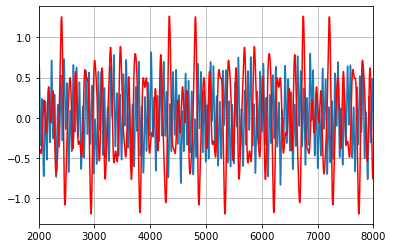

In [30]:
new_synthesis = np.fft.ifft(fft_synthesis)
new_synthesis = new_synthesis / np.max(new_synthesis)
plt.plot( new_synthesis) 
plt.plot( add_sig, 'r-')
plt.grid()
plt.xlim(2000,8000)

Text(0, 0.5, 'Amplitude')

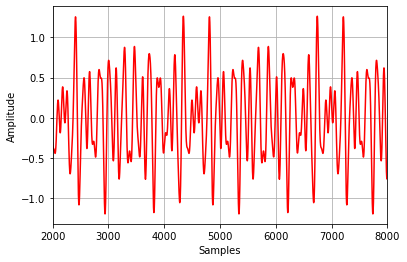

In [31]:
plt.plot( add_sig, 'r-')
plt.grid()
plt.xlim(2000,8000); plt.xlabel('Samples'); plt.ylabel('Amplitude')

In [32]:
ipd.Audio(new_synthesis, rate=fs)

/Users/scottoshiro/opt/anaconda3/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [33]:
ipd.Audio(x, rate=fs)

In [34]:
ipd.Audio(b, rate=fs)

In [35]:
ipd.Audio(add_sig, rate=fs)